In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as clrs
import matplotlib.cm as cm
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
import collections
import string
from collections import OrderedDict
import random
from collections import Counter
import statistics
num_regex = re.compile(r'\d+')
import os
import operator
import pandas as pd

## This notebook is used to plot the genotype distributions for some given runs (the pink and blue plots)

In [2]:
nRuns = 100
runID_offsets = [0, 100]
duration = 4368 #duration of sims in hours - equivalent to 26 weeks
dates = ["24-Sep-2020", "09-Oct-2020"] #dates the simulations were performed on
pc_res = [14, 15, 16] #percentages of the populations which are resistant to the applied biocide
phase2_str = "phase2"

#parameters for the log normal distributions used
#[scale, sigma]
log_norm_params_14pcRes = [2.703747953786337, 0.5690825284230452]
log_norm_params_15pcRes = [2.6133256846855746, 0.6260058161550592]
log_norm_params_16pcRes = [2.47772924764521, 0.7060073500033884]

In [25]:
def getFilepathToGenoRuns(date, pc_res, phase):
    '''
    creates a string with the file location of the genotype distributions (all the run_ID files)
    '''
    
    return "geno_distb_data_"+phase+"/"+str(pc_res)+"_resistant-"+date


def getEventCountersDataframe(date, pc_res, phase, sigma, duration):
    
    return pd.read_csv("geno_distb_data_"+phase+"/"+str(pc_res)+"_resistant-"+date+"/"+str(pc_res)+"_resistant-"+date+"-event_counters-sigma="+"{:.5f}".format(sigma)+"-t="+str(duration)+".0.csv")


def getListOfMeasurementTimes(directory_name):
    '''
    for each runID directory, this gets the filenames and extracts a list of the times they were sampled at.
    directory_name is of form path_to_files/runID_<n>
    
    returns: sorted list of the time vals, in string form with 2 decimal places
    '''
    time_list = []
    def get_numbers_from_filename(filename):
        return re.search(r'(\d+(?:\.\d+)?)', filename).group(0)
    
    for filename in os.listdir(directory_name):
        time_list.append(float(get_numbers_from_filename(filename)))

    return ["{:.2f}".format(float(t)) for t in sorted(time_list)]

In [33]:
#due to different sessions having different numbers of runs, we'll use the 
event_counters_14pc_24Sep = getEventCountersDataframe(dates[0], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_14pc_24Sep["date"] = "24-Sep-2020"
event_counters_15pc_24Sep = getEventCountersDataframe(dates[0], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_15pc_24Sep["date"] = "24-Sep-2020"
event_counters_16pc_24Sep = getEventCountersDataframe(dates[0], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_24Sep["date"] = "24-Sep-2020"

event_counters_14pc_09Oct = getEventCountersDataframe(dates[1], pc_res[0], phase2_str, log_norm_params_14pcRes[1], duration)
event_counters_14pc_09Oct["date"] = "09-Oct-2020"
event_counters_15pc_09Oct = getEventCountersDataframe(dates[1], pc_res[1], phase2_str, log_norm_params_15pcRes[1], duration)
event_counters_15pc_09Oct["date"] = "09-Oct-2020"
event_counters_16pc_09Oct = getEventCountersDataframe(dates[1], pc_res[2], phase2_str, log_norm_params_16pcRes[1], duration)
event_counters_16pc_09Oct["date"] = "09-Oct-2020"

In [34]:
all_event_counters_14pc = pd.concat([event_counters_14pc_24Sep, event_counters_14pc_09Oct], ignore_index=True)
all_event_counters_15pc = pd.concat([event_counters_15pc_24Sep, event_counters_15pc_09Oct], ignore_index=True)
all_event_counters_16pc = pd.concat([event_counters_16pc_24Sep, event_counters_16pc_09Oct], ignore_index=True)
#all_event_counters_14pc[all_event_counters_14pc["bf_thickness"] > 0]
print((all_event_counters_14pc[all_event_counters_14pc["runID"]==198]["date"].values[0]))

09-Oct-2020


In [35]:
def getGenoDistbDict(runID, pc_res, phase_val, event_counters):
    '''
    gets a dict containing the geno distbs over time.
    each key is the time step.
    each entry is a dataframe containing the genotypes in each microhabitat
    '''
    
    runID_key = "runID_"+str(runID)
    #due to the varying no. of runs in each session, (depending on % resistant) we'll use the counters dataframe to get the date
    date = event_counters[event_counters["runID"]==runID]["date"].values[0]
    #date = dates[runID//nRuns] #gets the relevant date from the list of dates, according to the runID (100 runs per session, starting at 0)
    
    directoryPath = getFilepathToGenoRuns(date=date, pc_res=pc_res, phase=phase_val)
    filepath_runID = directoryPath+"/"+runID_key
    
    geno_time_dict = {} #dictionary containing geno dataframes for each timestep
    time_list = getListOfMeasurementTimes(filepath_runID) #sorted list of the times that the genos were sampled at in this run
    
    for t in time_list:
            
        filepath_time = filepath_runID+"/geno_distb-t="+t+".csv"

        #need to swap the rows and columns so that the microhabitat is the key in the dataframe
        #geno_df = pd.read_csv(filename, header=None).T
        geno_df = pd.DataFrame([line.strip().split(',') for line in open(filepath_time, 'r')]).T
        #geno
        new_header = geno_df.iloc[0] #grab the first row for the header
        geno_df = geno_df[1:] #take the data less the header row
        geno_df.columns = new_header #set the header row as the df header

        geno_df = geno_df.astype(float)

        #round the time to the nearest integer value to make reading it in easier
        #the [-3] is so the decimal point and decimal numbers are removed when casting the string to an int
        geno_time_dict[int(t[:-3])] = geno_df
    
    return geno_time_dict
    
    

In [36]:
x = getGenoDistbDict(184, 14, phase2_str, all_event_counters_14pc)

In [37]:
def plotGenoDistbsInSystemOverTime(geno_dict, runID, pc_res, event_counters):
    '''
    This is the method that makes the big blue and pink plots, showing the distribution of genotypes over time throughout the system
    Input is the geno_dict, where each key is the timestep and each entry is a dataframe where each column is the genotypes in each microhabitat
    '''
    
    #make a new dict where each key is the timestep, each entry is the dataframe values condensed into a single array (2D dataframe -> 1D array)
    collated_geno_dict = {}
    n_dict = {} #this will save the pop size N at time t (bit overengineered, this is kinda shoehorned in to plot vs N instead of t)
    min_geno_val = 9e9
    max_geno_val = 0. #this will be updated to be the genotype of the most resistant bacteria in the system, used for scaling the colourmap
    
    for t in geno_dict.keys():
        #gets all the genotypes from the dataframe, removes NaNs and converts to 1D numpy array
        #round the genotypes to n decimal places
        processed_genos = np.around(geno_dict[t].values[~np.isnan(geno_dict[t].values)].flatten(), decimals=0)
        max_geno_val = max(np.max(processed_genos), max_geno_val)
        min_geno_val = min(np.min(processed_genos), min_geno_val)
        #dict containing the species genotypes (keys) and no. of ocurrences of each (values)
        geno_counts = Counter(processed_genos)
        n_bac = sum(geno_counts.values())
#         print(n_bac)
#         print(geno_counts.keys())
#         print(geno_counts.values())
        #sort the geno counts so they're arranged in order of increasing resistance
        geno_counts = dict(sorted(geno_counts.items()))
        
        for key in geno_counts:
            geno_counts[key] = geno_counts[key]/n_bac
        #divide the counts by the total no. of bacteria
#         normalised_geno_counts = {k: v/n_bac for k, v in geno_counts}
        
#         print()
#         print(geno_counts.keys())
#         print(geno_counts.values())
#         #print(max_geno_val)
        collated_geno_dict[t] = geno_counts
        n_dict[t] = n_bac
        
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12

    colour_list = []
    t_last = 0
    for t in collated_geno_dict.keys():
        bar_ypos = 0 #used to adjust the bottom of the bar chart so we can stack bacteria on top of one another
        for geno_val in collated_geno_dict[t].keys():
            #print(geno_val)
            percent_of_max_r = geno_val/max_geno_val #how resistant is this genotype compared to the most resistant one
            geno_colour = (percent_of_max_r, 0.3*percent_of_max_r, 0.42) #colour representing the genotype's resistance
            #colour_list.append(geno_colour)
            geno_colour2 = cm.magma(percent_of_max_r)
            
            bars = ax.bar(x = n_dict[t], height=collated_geno_dict[t][geno_val], bottom=bar_ypos, color=geno_colour2, width=1100, label=geno_val)
            bar_ypos += collated_geno_dict[t][geno_val]
        
        t_last = float(t)
        n_last = float(n_dict[t])
    #cmap = clrs.LinearSegmentedColormap.from_list("", colour_list)
#     handles, labels = ax.get_legend_handles_labels()
#     unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#     ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
#     plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1.02,0.8), fontsize='large', ncol=3)
    
        #we've now got all the genos over time, sorted and normalised, and know the max val.
    #now we need to translate this into a bar chart

    
    cmap_string = "magma"
    sm = plt.cm.ScalarMappable(cmap=cmap_string)
    sm.set_array([])
    n_ticks = 6

    cbar = fig.colorbar(sm)
    cbar.ax.locator_params(nbins=n_ticks)
    ctick_labels = ["{:.1f}".format(x) for x in list(np.linspace(min_geno_val, max_geno_val, n_ticks))]
    cbar.ax.set_yticklabels(ctick_labels) 
    cbar.ax.tick_params(labelsize=labelSize)
    cbar.set_label("resistance", fontsize=labelSize)
    
    ax.set_ylabel('$n_i/N$', fontsize=labelSize)
    ax.set_xlabel('N', fontsize=labelSize)
    plt.xticks(fontsize=18)
    plt.locator_params(axis='x', nbins=4)
    plt.yticks(fontsize=18)
    
    #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
    plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
    plt.xlim(0, n_last)
    plt.ylim(0, 1)
    
    plt.savefig('geno_distb_plots/'+str(pc_res)+"pc_res-runID_"+str(runID))
    plt.show()
    
    
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 6.2)
    titleSize = 16
    labelSize = 16
    numbersize = 12
    legendsize = 10
    IDsize=12
    
    #print(list(n_dict.keys()))
    ax.plot(list(n_dict.keys()), list(n_dict.values()))
    ax.set_ylabel('$N$', fontsize=labelSize)
    ax.set_xlabel('t', fontsize=labelSize)
    plt.xticks(fontsize=18)
    plt.locator_params(axis='x', nbins=4)
    plt.yticks(fontsize=18)
    
    #print(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values)
    plt.title(str(pc_res)+'% resistant,    '+'run: '+str(runID)+'    thickness: '+str(event_counters.loc[event_counters['runID']==runID]["bf_thickness"].values[0])+"$\mu m$", fontsize=titleSize)
    
    
    plt.show()
            
        
        
        
    
        
    
    

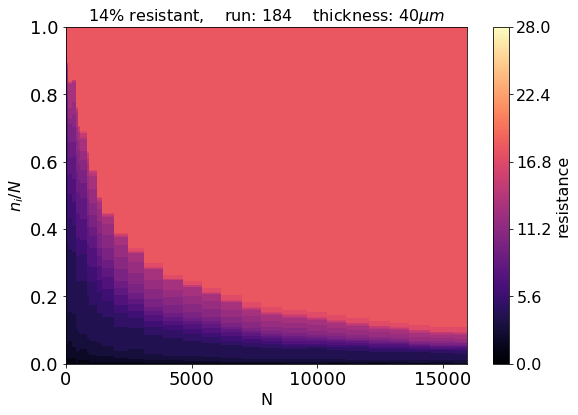

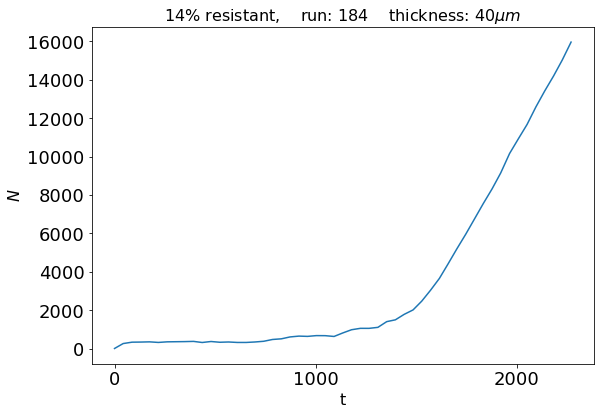

In [38]:
plotGenoDistbsInSystemOverTime(x, runID=184, pc_res=14, event_counters=all_event_counters_14pc)

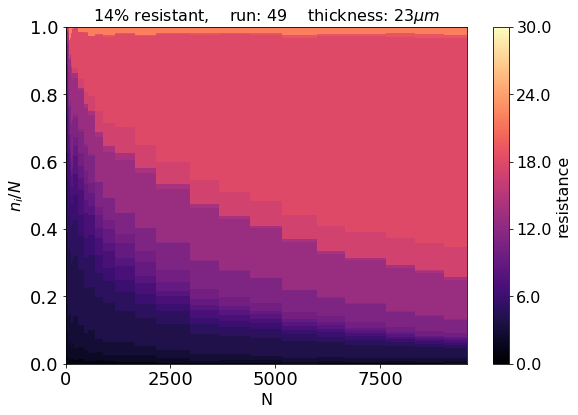

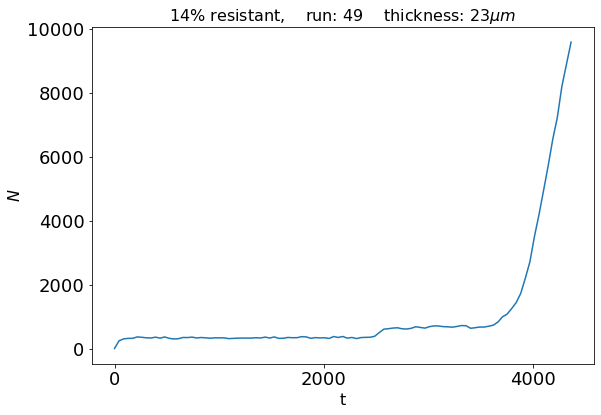

In [39]:
run_id = 49
pc_resistant = 14
x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str, event_counters=all_event_counters_14pc)
plotGenoDistbsInSystemOverTime(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_14pc)

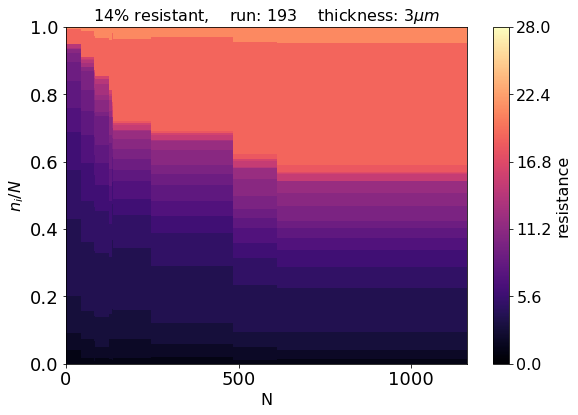

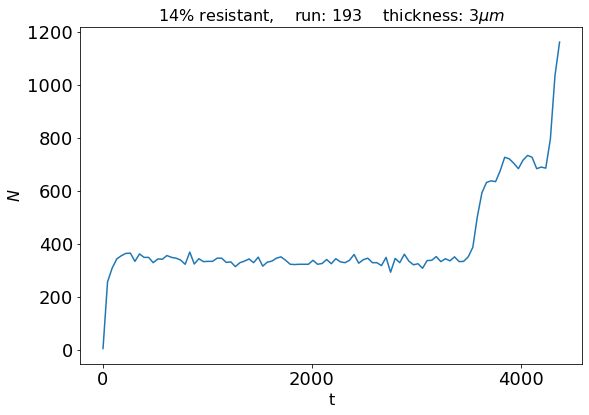

In [51]:
run_id = 193
pc_resistant = 14
x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str)
plotGenoDistbsInSystemOverTime(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_14pc)

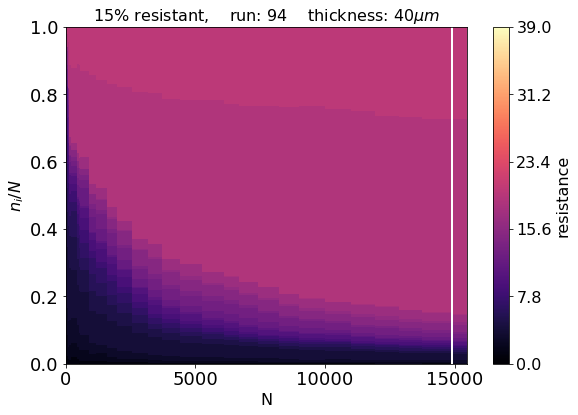

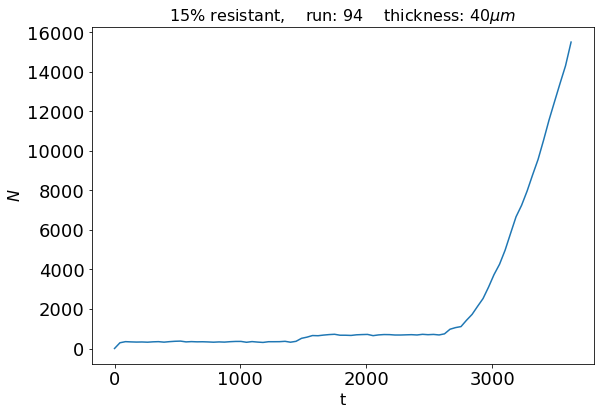

In [52]:
run_id = 94
pc_resistant = 15
x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str)
plotGenoDistbsInSystemOverTime(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_15pc)

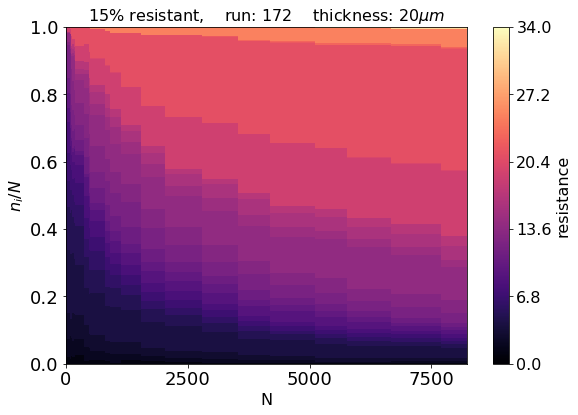

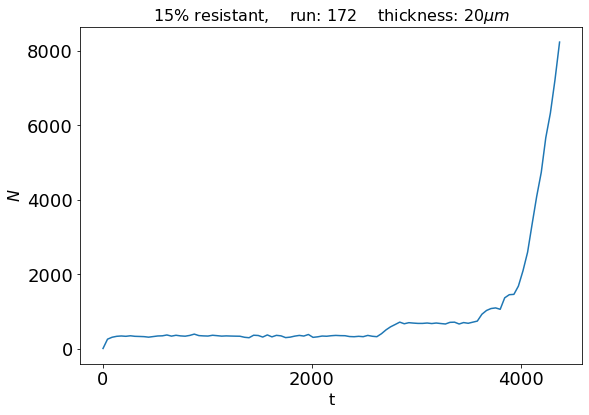

In [53]:
run_id = 172
pc_resistant = 15
x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str)
plotGenoDistbsInSystemOverTime(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_15pc)

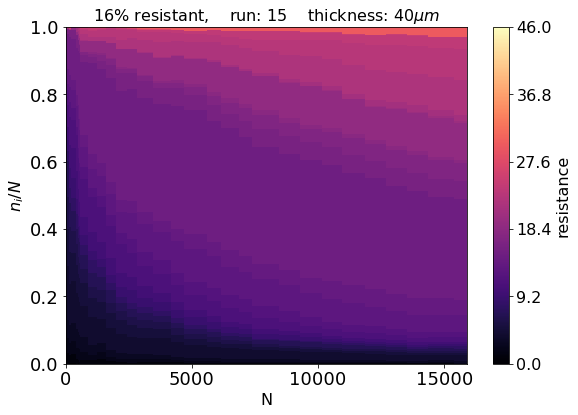

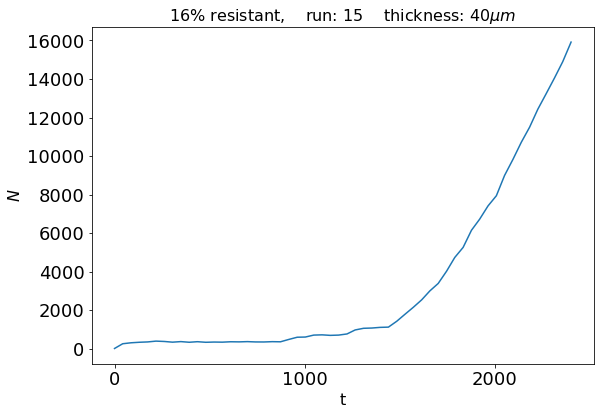

In [54]:
run_id = 15
pc_resistant = 16
x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str)
plotGenoDistbsInSystemOverTime(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_16pc)

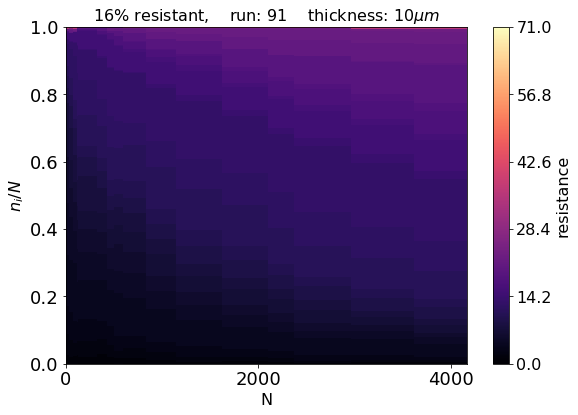

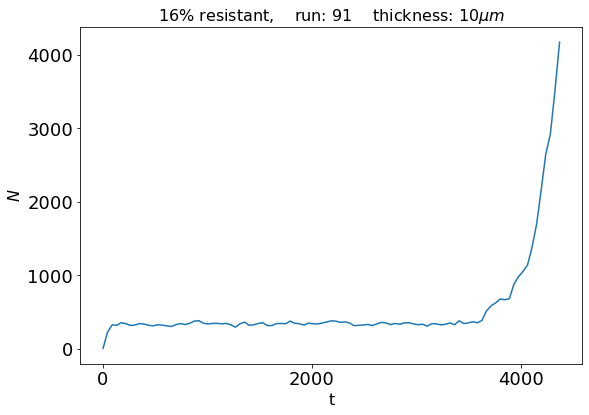

In [55]:
run_id = 91
pc_resistant = 16
x = getGenoDistbDict(runID=run_id, pc_res=pc_resistant, phase_val=phase2_str)
plotGenoDistbsInSystemOverTime(x, runID=run_id, pc_res=pc_resistant, event_counters=all_event_counters_16pc)

In [225]:
s

NameError: name 's' is not defined